In [0]:
from google.colab import drive
drive.mount('/content/drive') 
#drive.flush_and_unmount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


[link text](https:// [link text](https:// [link text](https://)))So each image has a corresponding segmentation mask, where each color correspond to a different instance. Let's write a `torch.utils.data.Dataset` class for this dataset.

In [0]:
import json
import cv2
import itertools
import torch
from PIL import Image
class ZebraDataset(torch.utils.data.Dataset):
  def __init__(self, path, jfile, transform = None):
    self.transform = transform
    self.path = path
    self.data = []
    dataset_dicts = []
    json_file = os.path.join(path, jfile)
    with open(json_file) as f:
        imgs_anns = json.load(f)

    for _, v in imgs_anns.items():
        record = {}
        annos = v["regions"]
        if not annos:
          continue

        filename = os.path.join(path, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            #not anno["region_attributes"]
            classattr = anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = list(itertools.chain.from_iterable(poly))
            if not classattr:
                cls = 0
            else :
                cls = int(classattr["class"])

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "segmentation": [poly],
                "category_id": cls,

                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    self.data = dataset_dicts[1:]
    
  
  def __len__(self):
    return len(self.data)

  def __getitem__(self,id):
    data = self.data[id]
    file = Image.open(os.path.join(self.path,data["file_name"])).convert('RGB')
    target={}
    boxes = []
    label=[]
    for ann in data["annotations"]:
      boxes.append(ann["bbox"])
      label.append(int(ann["category_id"]))
    
    #print(len(boxes),len(label))
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    image_id = torch.tensor([id])
    target["boxes"] = boxes
    target["labels"] = torch.as_tensor(label, dtype=torch.int64)
    target["labels"] = target["labels"]+1
    target["image_id"] = image_id
    target["area"] = (boxes[:,3] - boxes[:,1]) * (boxes[:,2] - boxes[:,0])
    target["iscrowd"] = torch.zeros(len(data["annotations"]))
    


    if self.transform is not None:
      file, target = self.transform(file,target)
    return file, target

That's all for the dataset. Let's see how the outputs are structured for this dataset

In [0]:
import os
import numpy as np

root = "/content/drive/My Drive/Colab Notebooks/data/images/gray"
jfile = "set 1-125.json"
jfile2 = "set 126-225.json"
dataset = ZebraDataset(root,jfile)
d2 = ZebraDataset(root,jfile2)
dataset = dataset + d2
len(dataset)

119

So we can see that by default, the dataset returns a `PIL.Image` and a dictionary
containing several fields, including `boxes`, `labels` and `masks`.

In [0]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
  # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # replace the classifier with a new one, that has
    # num_classes which is user-defined
    # 1 class (person) + background
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model


In [1]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 6127 (delta 27), reused 29 (delta 13), pack-reused 6074
Receiving objects: 100% (6127/6127), 9.60 MiB | 12.64 MiB/s, done.
Resolving deltas: 100% (4076/4076), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be37608 version check against PyTorch's CUDA version




Let's write some helper functions for data augmentation / transformation, which leverages the functions in `refereces/detection` that we have just copied:


In [0]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))

    return T.Compose(transforms)

#### Note that we do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Mask R-CNN model.

### Putting everything together

We now have the dataset class, the models and the data transforms. Let's instantiate them

In [0]:
# use our dataset and defined transformations
dataset = ZebraDataset(root,jfile, get_transform(train=True))
dataset = dataset + ZebraDataset(root,jfile2, get_transform(train=True))
dataset_test = ZebraDataset(root, jfile,get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:len(dataset)-1])
dataset_test = torch.utils.data.Subset(dataset_test, indices[:2])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)
len(dataset)


118

Now let's instantiate the model and the optimizer

In [0]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 6

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:03<00:00, 45.0MB/s]


And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [0]:
# let's train it for 10 epochs
model=model_l
num_epochs = 100

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    optimizer.step()
    # evaluate on the test dataset
    #evaluate(model, data_loader, device=device)
    evaluate(model,data_loader_test,device=device)

NameError: ignored

Now that training has finished, let's have a look at what it actually predicts in a test image

In [0]:
# pick one image from the test set
import transforms as T
from PIL import Image
img  = Image.open('/content/drive/My Drive/Colab Notebooks/data/images/gray/img-0000269.jpg').convert('RGB')
t=get_transform(train=False)
t = T.ToTensor()
img = t(img,_)
img=img[0].to(device)
# put the model in evaluation mode
model = model.to(device)
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])


![alt text](https://)Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

In [0]:
img=img.cpu()
prediction

[{'boxes': tensor([[149.0403,   9.5770, 198.6780, 132.2771],
          [163.4819,  25.4575, 223.1037, 131.6784],
          [110.6671,  20.3752, 138.1192, 134.8659],
          [129.0912,  14.0125, 168.4431, 134.6045],
          [104.9065,  16.8731, 130.2450, 135.2939],
          [103.8953,  18.8527, 128.0318, 129.3419],
          [129.7998,  17.4221, 164.9010, 141.5283]], device='cuda:0'),
  'labels': tensor([4, 4, 2, 3, 5, 1, 2], device='cuda:0'),
  'scores': tensor([0.9997, 0.9996, 0.9930, 0.9925, 0.7497, 0.5348, 0.1450],
         device='cuda:0')}]

Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

[{'boxes': tensor([[149.0403,   9.5770, 198.6780, 132.2771],
        [163.4819,  25.4575, 223.1037, 131.6784],
        [110.6671,  20.3752, 138.1192, 134.8659],
        [129.0912,  14.0125, 168.4431, 134.6045],
        [104.9065,  16.8731, 130.2450, 135.2939],
        [103.8953,  18.8527, 128.0318, 129.3419],
        [129.7998,  17.4221, 164.9010, 141.5283]], device='cuda:0'), 'labels': tensor([4, 4, 2, 3, 5, 1, 2], device='cuda:0'), 'scores': tensor([0.9997, 0.9996, 0.9930, 0.9925, 0.7497, 0.5348, 0.1450],
       device='cuda:0')}]


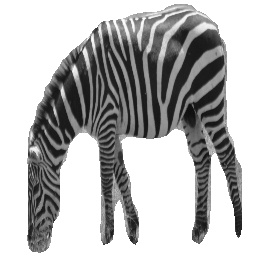

In [0]:
print(prediction)
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())


![alt text](https://)And let's now visualize the top predicted segmentation mask. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])
4
4
2
3
5


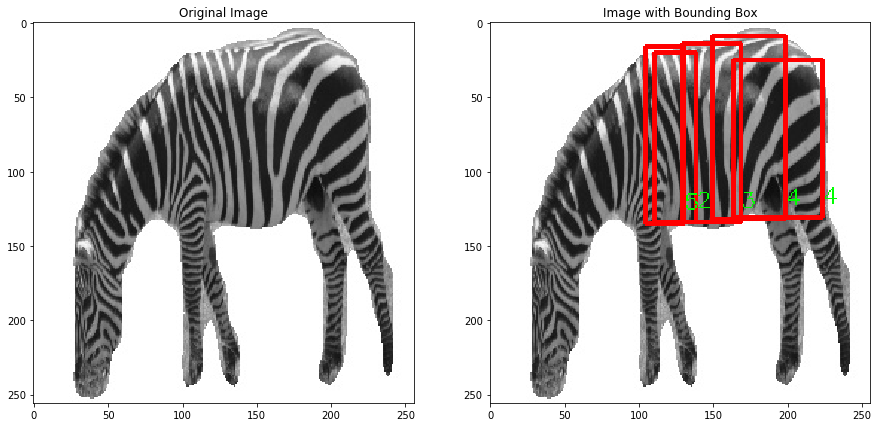

In [0]:
import matplotlib.pyplot as plt
height, width, _ = img.shape
print(img.shape)
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(img.permute(1,2,0))
img_bbox = img.permute(1,2,0).numpy().copy()
box  = prediction[0]['boxes']
box=box.cpu().numpy().copy()
lab = prediction[0]['labels']
lab=lab.to('cpu').numpy()
for i in  range(0,5):
    xmin = box[i][0]
    ymin = box[i][1]
    xmax = box[i][2]
    ymax = box[i][3]
    xmin = int(xmin)
    xmax = int(xmax)
    ymin = int(ymin)
    ymax = int(ymax)
    class_name = str(lab[i])
    print(class_name)
    cv2.rectangle(img_bbox,(xmin,ymin),(xmax,ymax),(255,0,0),2)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img_bbox,class_name,(xmax,ymax-10), font, 0.5,(0,255,0),1)
plt.subplot(1,2,2)
plt.title('Image with Bounding Box')
plt.imshow(img_bbox)
plt.show()

In [0]:
model

In [0]:
for m in model.parameters():
  print(m,m.requires_grad)

In [0]:
dir(model)


In [0]:
model.roi_heads

In [0]:
PATH = "/content/drive/My Drive/Colab Notebooks/data/images/gray/faster.model"
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
from PIL import Image

In [0]:
model_l = get_instance_segmentation_model(6)
model_l.load_state_dict(torch.load(PATH))
model = model_l

In [0]:
# pick one image from the test set
#model = model_l.to(device)
import transforms as T
def get_pred(path):
  img  = Image.open(path).convert('RGB')
  t=get_transform(train=False)
  t = T.ToTensor()
  img = t(img,_)
  img=img[0].to(device)
  # put the model in evaluation mode
  model_l.eval()
  with torch.no_grad():
      prediction = model_l([img.to(device)])
  return img,prediction

In [0]:
prediction

In [0]:
import matplotlib.pyplot as plt
def pred_plot(img,pred):
  img=img.cpu()
  height, width, _ = img.shape
  #print(img.shape)
  plt.figure(figsize=(15,10))
  plt.subplot(1,2,1)
  plt.title('Original Image')
  plt.imshow(img.permute(1,2,0))
  img_bbox = img.permute(1,2,0).numpy().copy()
  pat,box,lab  = get_pat(pred[0])
  print(pat)
  for i in  range(0,len(box)):
      xmin = box[i][0]
      ymin = box[i][1]
      xmax = box[i][2]
      ymax = box[i][3]
      xmin = int(xmin)
      xmax = int(xmax)
      ymin = int(ymin)
      ymax = int(ymax)
      class_name = str(lab[i])
      cv2.rectangle(img_bbox,(xmin,ymin),(xmax,ymax),(255,0,0),1)
      font = cv2.FONT_HERSHEY_SIMPLEX
      cv2.putText(img_bbox,class_name,(xmax,ymax-10), font, 0.5,(0,255,0),2)
  cv2.putText(img_bbox, pat, (20,20), font, 0.5,(0,0,0),2)
  plt.subplot(1,2,2)
  plt.title('Image with Bounding Box')
  plt.imshow(img_bbox)
  plt.show()

In [0]:
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [0]:
import time
model = model.to(device)
fx,fy,fail=[],[],[]
tot_cur = 0
tot = 0
model = model.eval()
for image, targets in iter(data_loader_test):
  images = list(image.to(device) for image in image)
  targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
  with torch.no_grad():
    pred = model(images)
  x = [[(k.cpu().numpy().astype(int).tolist(),l.cpu().numpy().astype(int)) for k,l in zip(x["boxes"],x["labels"])] for x in targets]
  y = [[(k.cpu().numpy().astype(int).tolist(),l.cpu().numpy().astype(int),m.cpu().numpy().squeeze()) for k,l,m in zip(y["boxes"],y["labels"],y["scores"]) if m>0.6 ] for y in pred]
  #x= [(sorted(l, key= lambda r : r[0][0]),l[1]) for l in x]
  #y= [(sorted(l, key= lambda r : r[0][0]),l[1]) for l in y]
  for x1,y1 in zip(x,y):
    for box,lab in x1:
      hook = box[0]
      pos = [l for b,l,s in y1 if abs(hook-b[0])<10]
      if lab in pos:
        tot_cur+=1
      tot+=1

In [0]:
import engine
from coco_utils import get_coco_api_from_dataset
from coco_eval import CocoEvaluator
iou_types = engine._get_iou_types(model)
coco_evaluator = CocoEvaluator(coco, iou_types)

NameError: ignored

Model at epochs 24, on training, test dataset, within bounding box error of 10; Stripe Classification Accuracy

In [0]:
tot_cur/tot

In [0]:
tot_cur/tot

IoU on test data

In [0]:
evaluate(model,data_loader_test,device)

In [0]:
labels = {
    1: 'l',
    2: 'y',
    3: 'YYY',
    4: 'c',
    5: 'ƛ'
}
labels

{1: 'l', 2: 'y', 3: 'YYY', 4: 'c', 5: 'ƛ'}

In [0]:
def get_pat(Y):
  Y = [(b.cpu().numpy().astype(int).tolist(),c.cpu().numpy().squeeze().tolist()) for b,c,s in zip(Y["boxes"],Y["labels"],Y["scores"]) if s>0.7]
  Y = sorted(Y, key=lambda r: r[0][0])
  pat = [labels[c] for b,c in Y]
  box = [b for b,c in Y]
  cls = [c for b,c in Y]
  return ''.join(l for l in pat), box, cls
get_pat(prediction[0])

('', [], [])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/data/images/gray/
ccyyll


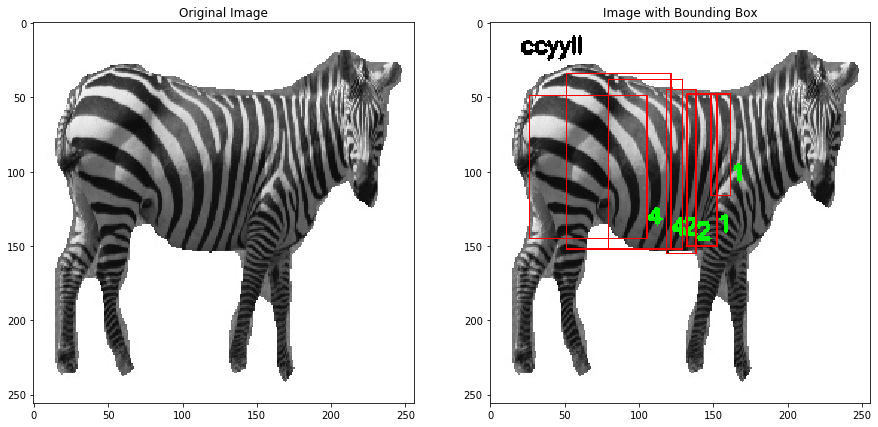

In [116]:
pred,img = 1,1
for i in range(312,313):
  path = '/content/drive/My Drive/Colab Notebooks/data/images/gray/'
  im = 'img-0000' + str(i) + '.jpg'
  print(path)
  img11,pred  = get_pred(path+im)
  pred_plot(img11,pred)

For Zebra with Pattern cccyyll

/content/drive/My Drive/Colab Notebooks/data/images/gray/


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cc


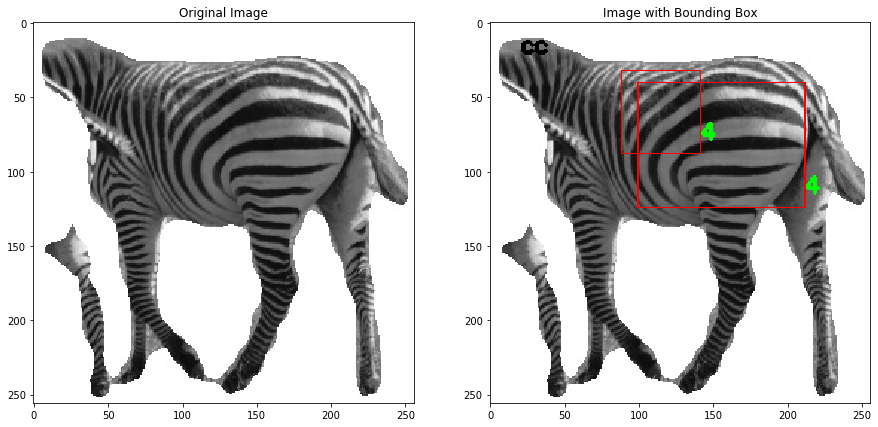

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/data/images/gray/
lyYYYccc


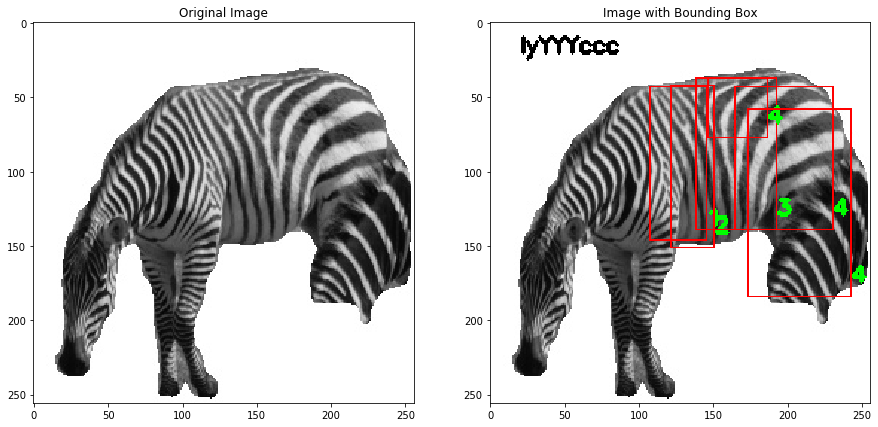

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/data/images/gray/
lyYYYYYYccc


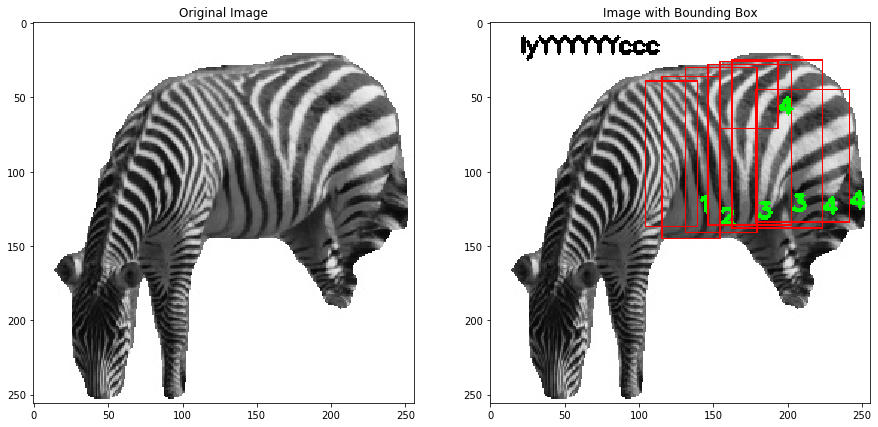

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/drive/My Drive/Colab Notebooks/data/images/gray/
cyy


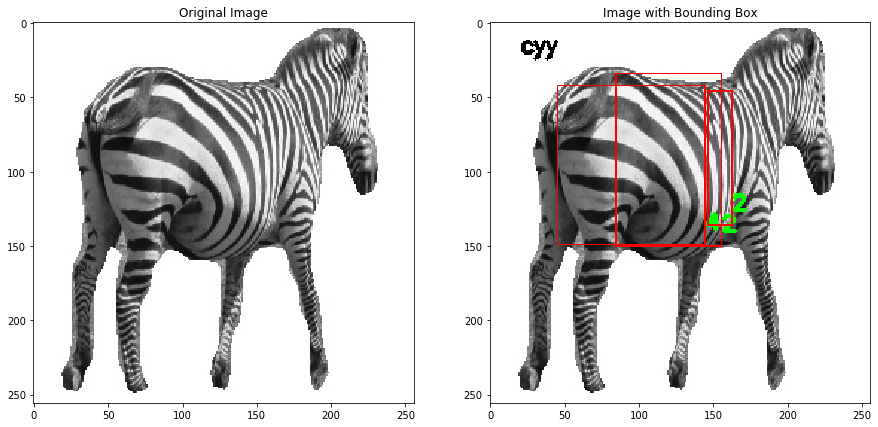

In [139]:
for i in range(731,735):
  path = '/content/drive/My Drive/Colab Notebooks/data/images/gray/'
  im = 'img-0000' + str(i) + '.jpg'
  print(path)
  img11,pred  = get_pred(path+im)
  pred_plot(img11,pred)


In [0]:
dataset[1][1]['labels']

tensor([5, 2, 3, 4, 4, 4])

In [0]:
t = torch.zeros(6)

tensor([137.,  61., 151., 153.])

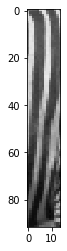

In [0]:
import matplotlib.pyplot as plt
d = dataset[2]
im = d[0]
box = d[1]['boxes'][0]
im = im.permute(1,2,0)
im = im[int(box[1]):int(box[3]),int(box[0]):int(box[2])]
plt.imshow(im)
box

In [0]:
data

NameError: ignored

In [0]:
t

tensor([  0., 150., 148.,  53., 282.,  19.])

In [106]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
i=0
flag=0
for ix in range(50,100):
  d=dataset[ix]
  if flag == 1:
    break
  for id,label in enumerate(d[1]["labels"]):
    if label == 5:
      im = d[0]
      box = d[1]['boxes'][id]
      im = im.permute(1,2,0)
      im = im[int(box[1])+2:int(box[3])+2,int(box[0]):int(box[2])]
      plt.subplot(3,3,i+1)
      plt.tight_layout()
      plt.imshow(im)
      plt.xticks([])
      plt.yticks([])
      i+=1
    if(i>8):
        flag=1
        break  
fig

IndexError: ignored

<Figure size 720x720 with 0 Axes>

In [0]:
prediction

[{'boxes': tensor([[149.0403,   9.5770, 198.6780, 132.2771],
          [163.4819,  25.4575, 223.1037, 131.6784],
          [110.6671,  20.3752, 138.1192, 134.8659],
          [129.0912,  14.0125, 168.4431, 134.6045],
          [104.9065,  16.8731, 130.2450, 135.2939],
          [103.8953,  18.8527, 128.0318, 129.3419],
          [129.7998,  17.4221, 164.9010, 141.5283]], device='cuda:0'),
  'labels': tensor([4, 4, 2, 3, 5, 1, 2], device='cuda:0'),
  'scores': tensor([0.9997, 0.9996, 0.9930, 0.9925, 0.7497, 0.5348, 0.1450],
         device='cuda:0')}]

In [0]:
dataset_test[0][0].unsqueeze(3).squeeze().shape
d = next(iter(data_loader_test))[0]
model(d.gpu())

AttributeError: ignored

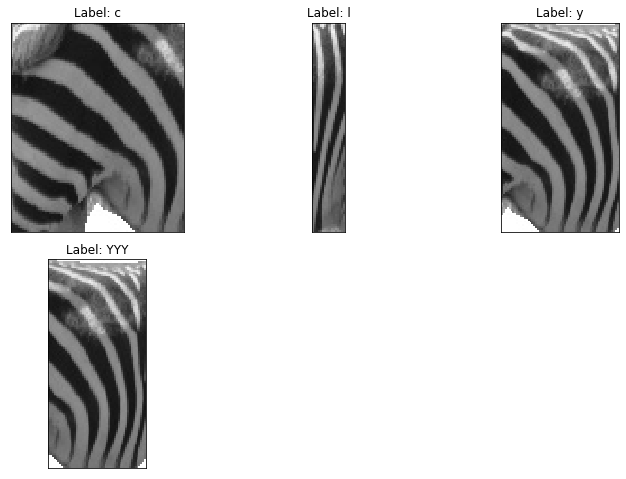

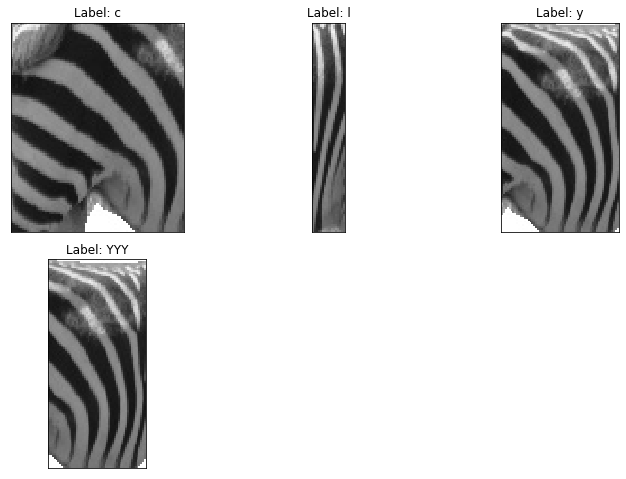

In [129]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
i=0
flag=0
prediction = pred
im = img11.cpu()
for id,label in enumerate(pred[0]["labels"]):
      if(pred[0]["scores"][id]<0.6):
        continue
      box = pred[0]['boxes'][id]
      im = img11.cpu()
      im = im.permute(1,2,0)
      im = im[int(box[1]):int(box[3]),int(box[0]):int(box[2])]
      plt.subplot(3,3,i+1)
      plt.tight_layout()
      plt.title("Label: {}".format(labels[label.cpu().numpy().squeeze().tolist()]))
      plt.imshow(im)
      plt.xticks([])
      plt.yticks([])
      i+=1
fig

In [86]:
pred

[{'boxes': tensor([[121.1123,  69.2634, 203.5330, 161.6741],
          [115.4396,  73.9950, 143.8422,  94.6620],
          [118.7861,  71.9156, 160.9115, 162.4677],
          [ 95.2785,  74.8928, 106.6415, 162.1545],
          [102.7021,  74.2380, 113.4450, 159.4724],
          [108.9071,  77.2835, 120.3612, 159.5056],
          [116.1750,  71.0996, 156.0358, 163.4443],
          [103.0431,  75.3783, 108.1463, 156.2983],
          [109.3624,  80.9619, 122.7948, 162.8370]], device='cuda:0'),
  'labels': tensor([4, 4, 4, 1, 1, 1, 2, 1, 2], device='cuda:0'),
  'scores': tensor([0.9997, 0.9995, 0.9982, 0.9955, 0.9917, 0.9916, 0.1836, 0.0842, 0.0839],
         device='cuda:0')}]